In [6]:
import pandas as pd
import cv2 as cv
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from PIL import Image
import numpy as np
import random


In [7]:
df = pd.read_csv("archive/sports.csv")
df.head()

class id                 filepaths      labels data set
0         0  train/air hockey/001.jpg  air hockey    train
1         0  train/air hockey/002.jpg  air hockey    train
2         0  train/air hockey/003.jpg  air hockey    train
3         0  train/air hockey/004.jpg  air hockey    train
4         0  train/air hockey/005.jpg  air hockey    train

In [8]:
#Let's get rid of the spaces in labels right away
df.labels = df.labels.str.replace(' ', '_')
#Also, let's look at how many pictures of each sport do we have
df.labels.value_counts()

labels
football              201
formula_1_racing      200
nascar_racing         199
baseball              184
hockey                182
                     ... 
horseshoe_pitching    112
arm_wrestling         109
wingsuit_flying       108
ultimate              107
sky_surfing            69
Name: count, Length: 100, dtype: int64

In [9]:
#Since we have to classify 10 classes, I think the first 10 are good enough, since those are pretty distinct ones and also, they have nearly enough images
#(Lecturer said, that for classification task, there should be around 200-400 images per class)
#Also, I'm pretty sure it's supposed to be canoe slalom, not slamon, but my laziness is unimaginable, so I'm going to let it be.

In [10]:
Path_to_csv = "archive/"
size = 0
duplicate = 0
dictionary = {}

for img_path in df["filepaths"]:
    img_path = Path_to_csv + img_path
    img = cv.imread(img_path)

    #detecting format
    if img is None:
        print("Image {} not found".format(img_path))
        row_to_drop = df[df["filepaths"]==img_path].index
        df.drop(row_to_drop, inplace=True)
        continue

    #checking for duplicates
    hashed_image = hashlib.md5(img).hexdigest()
    if hashed_image not in dictionary:
        dictionary[hashed_image] = img_path
    else:
        duplicate += 1

    #checking size
    height, width = img.shape[:2]
    if height != width != 244:
        size += 1

print(f"Number of exact duplicates: {duplicate}")
print(f"Number of images with incorrect size: {size}")

Image archive/train/high jump/159.lnk not found
Number of exact duplicates: 0
Number of images with incorrect size: 0


In [11]:
#We can see, that there is a one image is not image at all, so we have to drop it.
#There are no exact duplicates in the dataset
#All images have correct size
df.labels.value_counts()

labels
football              201
formula_1_racing      200
nascar_racing         199
baseball              184
hockey                182
                     ... 
horseshoe_pitching    112
arm_wrestling         109
wingsuit_flying       108
ultimate              107
sky_surfing            69
Name: count, Length: 100, dtype: int64

In [12]:
#Now we will filter the dataset to classes we want to classify plus one unknown class, build from the other classes
#Unknow class size will be adjusted to match size of other classes

dataframe = df.copy()

selected = ["football", "formula_1_racing","nascar_racing","baseball","hockey","basketball","olympic_wrestling","rugby","canoe_slamon", "roller_derby"]
all_selected = selected + ["unknown"]

for index, label in dataframe['labels'].items():
    if label not in selected:
        dataframe.loc[index, 'labels'] = "unknown"

#We also need to update classes
dataframe.rename(columns={'class id': 'class_id'}, inplace=True)
dataframe["class_id"] = pd.Categorical(dataframe["labels"], categories=all_selected).codes
dataframe.head()

class_id                 filepaths   labels data set
0        10  train/air hockey/001.jpg  unknown    train
1        10  train/air hockey/002.jpg  unknown    train
2        10  train/air hockey/003.jpg  unknown    train
3        10  train/air hockey/004.jpg  unknown    train
4        10  train/air hockey/005.jpg  unknown    train

In [13]:
#at this point, we can drop the label and use one hot on class_id, which is basically our new label
reduced_dataframe = dataframe.copy()
reduced_dataframe.drop(["labels"], axis=1, inplace=True)
one_hot = pd.get_dummies(reduced_dataframe['class_id'])
reduced_dataframe = reduced_dataframe.drop(["class_id"], axis=1)
reduced_dataframe = one_hot.join(reduced_dataframe)
reduced_dataframe.head()

0      1      2      3      4      5      6      7      8      9    10  \
0  False  False  False  False  False  False  False  False  False  False  True   
1  False  False  False  False  False  False  False  False  False  False  True   
2  False  False  False  False  False  False  False  False  False  False  True   
3  False  False  False  False  False  False  False  False  False  False  True   
4  False  False  False  False  False  False  False  False  False  False  True   

                  filepaths data set  
0  train/air hockey/001.jpg    train  
1  train/air hockey/002.jpg    train  
2  train/air hockey/003.jpg    train  
3  train/air hockey/004.jpg    train  
4  train/air hockey/005.jpg    train

In [14]:
#Now we need to split the data into train, test and validation datasets
#In this case we will try to use already prepared separation
#TODO -> if anyone will have time, we should split it by ourselves as well
test_data = reduced_dataframe[reduced_dataframe["data set"] == "test"]
test_data = test_data.drop(["data set"], axis=1)
train_data = reduced_dataframe[reduced_dataframe["data set"] == "train"]
train_data = train_data.drop(["data set"], axis=1)
validation_data = reduced_dataframe[reduced_dataframe["data set"] == "valid"]
validation_data = validation_data.drop(["data set"], axis=1)
#Now we have all the datasets split.

In [15]:
train_data.describe(include="all")

0      1      2      3      4      5      6      7      8      9  \
count   13493  13493  13493  13493  13493  13493  13493  13493  13493  13493   
unique      2      2      2      2      2      2      2      2      2      2   
top     False  False  False  False  False  False  False  False  False  False   
freq    13302  13303  13304  13319  13321  13324  13326  13327  13329  13330   

           10                     filepaths  
count   13493                         13493  
unique      2                         13493  
top      True  train/wingsuit flying/98.jpg  
freq    11748                             1

In [16]:
#We need to balance out the unknown class, since it is extreme majority
unknown = train_data[train_data[10] == True].sample(n=200, random_state=10313)
known = train_data[train_data[10] == False]
train_data = pd.concat([unknown, known], ignore_index=True)
train_data.head()

0      1      2      3      4      5      6      7      8      9    10  \
0  False  False  False  False  False  False  False  False  False  False  True   
1  False  False  False  False  False  False  False  False  False  False  True   
2  False  False  False  False  False  False  False  False  False  False  True   
3  False  False  False  False  False  False  False  False  False  False  True   
4  False  False  False  False  False  False  False  False  False  False  True   

                  filepaths  
0         train/bmx/100.jpg  
1     train/cricket/118.jpg  
2        train/luge/025.jpg  
3  train/tug of war/033.jpg  
4  train/pole vault/092.jpg

In [17]:
train_data.describe(include="all")

0      1      2      3      4      5      6      7      8      9  \
count    1945   1945   1945   1945   1945   1945   1945   1945   1945   1945   
unique      2      2      2      2      2      2      2      2      2      2   
top     False  False  False  False  False  False  False  False  False  False   
freq     1754   1755   1756   1771   1773   1776   1778   1779   1781   1782   

           10            filepaths  
count    1945                 1945  
unique      2                 1945  
top     False  train/rugby/166.jpg  
freq     1745                    1

In [18]:
'''
BASE = "archive/"

def load_image_as_pixel_strips(path, size=(224, 224)):
    full_path = BASE + path  # FIXED
    img = Image.open(full_path).convert("RGB").resize(size)
    arr = np.asarray(img, dtype=np.float32) / 255.0   # normalize 0–1
    # return list of 224 flattened column vectors
    return [arr[:, col, :].flatten() for col in range(224)]

#create empty list of rows to append pixel data
pixel_matrix = []

#store all pixel strips into a list
for idx, row in train_data.iterrows():
    strips = load_image_as_pixel_strips(row["filepaths"])
    pixel_matrix.append(strips)   # shape: (224, 224*3)

#convert list → numpy array → DataFrame
pixel_array = np.array(pixel_matrix)         #shape = (N_samples, 224, 672)
pixel_df = pd.DataFrame(
    pixel_array.reshape(len(pixel_matrix), -1),
    columns=[f"pixel_{i}_{j}" for i in range(224) for j in range(672)]
)

#concatenate with original DF
train_data = pd.concat([train_data.reset_index(drop=True), pixel_df], axis=1)
train_data.head()
'''

'\nBASE = "archive/"\n\ndef load_image_as_pixel_strips(path, size=(224, 224)):\n    full_path = BASE + path  # FIXED\n    img = Image.open(full_path).convert("RGB").resize(size)\n    arr = np.asarray(img, dtype=np.float32) / 255.0   # normalize 0–1\n    # return list of 224 flattened column vectors\n    return [arr[:, col, :].flatten() for col in range(224)]\n\n#create empty list of rows to append pixel data\npixel_matrix = []\n\n#store all pixel strips into a list\nfor idx, row in train_data.iterrows():\n    strips = load_image_as_pixel_strips(row["filepaths"])\n    pixel_matrix.append(strips)   # shape: (224, 224*3)\n\n#convert list → numpy array → DataFrame\npixel_array = np.array(pixel_matrix)         #shape = (N_samples, 224, 672)\npixel_df = pd.DataFrame(\n    pixel_array.reshape(len(pixel_matrix), -1),\n    columns=[f"pixel_{i}_{j}" for i in range(224) for j in range(672)]\n)\n\n#concatenate with original DF\ntrain_data = pd.concat([train_data.reset_index(drop=True), pixel_df], 

5 rows × 150540 columns

In [19]:
BASE = "archive/"
TARGET_SIZE = (224, 224)

#normalizovanie aj nenormalizovanie na porovnanie
def load_image_as_array_unnormalized(path, size=TARGET_SIZE):
    full_path = BASE + path
    try:
        img = Image.open(full_path).convert("RGB").resize(size)
        arr = np.asarray(img, dtype=np.float32)
        return arr
    except:
        return None

def load_image_as_array_normalized(path, size=TARGET_SIZE):
    full_path = BASE + path
    try:
        img = Image.open(full_path).convert("RGB").resize(size)
        arr = np.asarray(img, dtype=np.float32) / 255.0  #<---normalizácia, delenim vznikne cislo emnsie ako 1 fo sure
        return arr
    except:
        return None

# --- Spustenie načítania dát (Vytvárame obe polia) ---

image_data_list_unnormalized = []
image_data_list_normalized = []
valid_indices = []

for idx, path in train_data["filepaths"].items():# vo for loope prechadzame vsetky riadky train_data "preformatuie" ich an NumPy arraye
    img_unnormalized = load_image_as_array_unnormalized(path)
    if img_unnormalized is not None:
        valid_indices.append(idx)
        image_data_list_unnormalized.append(img_unnormalized)

        #nacitame normalizovanu verziu len pre platne obrázky
        img_normalized = load_image_as_array_normalized(path)
        image_data_list_normalized.append(img_normalized)

#vytvorenie finalnych NumPy polí a ich naplnenie
X_train_unnormalized = np.array(image_data_list_unnormalized)
X_train_normalized = np.array(image_data_list_normalized)

print(f"Tvar nenormalizovaných dát: {X_train_unnormalized.shape}")
print(f"Tvar normalizovaných dát: {X_train_normalized.shape}")

Tvar nenormalizovaných dát: (1945, 224, 224, 3)
Tvar normalizovaných dát: (1945, 224, 224, 3)


In [20]:
print("## ️Analýza NumPy Polí")
print("-------------------------------------------------------")

#robime pre (X_train_unnormalized)

print("### Nenormalizované dáta (X_train_unnormalized)")
print(f"Tvar (Shape): {X_train_unnormalized.shape}")
print(f"Typ dát (Dtype): {X_train_unnormalized.dtype}")

# [0] -> prvý obrázok
# [0, 0] -> pixel v ľavom hornom rohu (riadok 0, stĺpec 0)
# [0, 0, :] -> všetky 3 RGB kanály
print("\nUkážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):")
print(X_train_unnormalized[0, 0, 0:5]) # Vypíše prvých 5 hodnôt R, G, B...

#kontrola rozsahu hodnôt (musia vyt medzi 0 až 255)
print(f"\nMinimum hodnôt: {np.min(X_train_unnormalized):.2f}")
print(f"Maximum hodnôt: {np.max(X_train_unnormalized):.2f}")

print("-------------------------------------------------------")

#normalizované dáta (X_train_normalized)

print("### Normalizované dáta (X_train_normalized)")
print(f"Tvar (Shape): {X_train_normalized.shape}")
print(f"Typ dát (Dtype): {X_train_normalized.dtype}")

#ukážka hodnôt z prvého pixelu prvého obrázku (porovnanie)
print("\nUkážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):")
print(X_train_normalized[0, 0, 0:5]) # Vypíše prvých 5 hodnôt R, G, B...

#kontrola rozsahu hodnôt (očakávame 0.0 až 1.0)
print(f"\nMinimum hodnôt: {np.min(X_train_normalized):.4f}")
print(f"Maximum hodnôt: {np.max(X_train_normalized):.4f}")


## ️Analýza NumPy Polí
-------------------------------------------------------
### Nenormalizované dáta (X_train_unnormalized)
Tvar (Shape): (1945, 224, 224, 3)
Typ dát (Dtype): float32

Ukážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):
[[38. 65. 48.]
 [18. 45. 28.]
 [22. 51. 33.]
 [ 9. 40. 22.]
 [ 5. 36. 18.]]

Minimum hodnôt: 0.00
Maximum hodnôt: 255.00
-------------------------------------------------------
### Normalizované dáta (X_train_normalized)
Tvar (Shape): (1945, 224, 224, 3)
Typ dát (Dtype): float32

Ukážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):
[[0.14901961 0.25490198 0.1882353 ]
 [0.07058824 0.1764706  0.10980392]
 [0.08627451 0.2        0.12941177]
 [0.03529412 0.15686275 0.08627451]
 [0.01960784 0.14117648 0.07058824]]

Minimum hodnôt: 0.0000
Maximum hodnôt: 1.0000


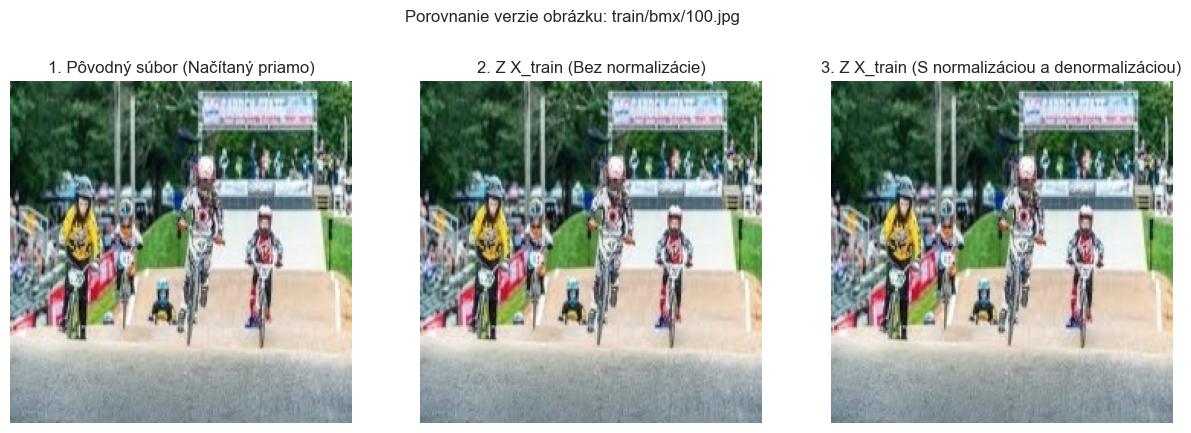

In [21]:
IMAGE_INDEX_TO_CHECK = 0
if len(X_train_unnormalized) == 0:
    print("Neboli načítané žiadne platné obrázky na porovnanie.")
else:
    original_df_index = valid_indices[IMAGE_INDEX_TO_CHECK]
    filepath_to_check = train_data.loc[original_df_index, "filepaths"]
    full_path_original = BASE + filepath_to_check

    #načítame pôvodný obrázok
    try:
        img_original_file = Image.open(full_path_original).convert("RGB").resize(TARGET_SIZE)
        img_original_file_array = np.asarray(img_original_file, dtype=np.uint8)

        #polia na zobrazenie a porovnanie
        #pole bez normalizácie (0-255 float -> uint8)
        img_unnormalized_array = X_train_unnormalized[IMAGE_INDEX_TO_CHECK].astype(np.uint8)
        #pole s normalizáciou (0-1 float -> denormalizácia -> uint8)
        img_normalized_denormalized_array = (X_train_normalized[IMAGE_INDEX_TO_CHECK] * 255).astype(np.uint8)

        #Vykreslenie všetkých troch obrázkov
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img_original_file_array)
        axes[0].set_title("1. Pôvodný súbor (Načítaný priamo)")
        axes[0].axis('off')

        axes[1].imshow(img_unnormalized_array)
        axes[1].set_title("2. Z X_train (Bez normalizácie)")
        axes[1].axis('off')

        axes[2].imshow(img_normalized_denormalized_array)
        axes[2].set_title("3. Z X_train (S normalizáciou a denormalizáciou)")
        axes[2].axis('off')

        plt.suptitle(f"Porovnanie verzie obrázku: {filepath_to_check}")
        plt.show()
    except FileNotFoundError:
        print(f"Chyba: Súbor nenájdený na ceste: {full_path_original}. Skontroluj Base a subor")

Generovanie dokončené. Finálny tvar X_train: (1945, 224, 224, 3)


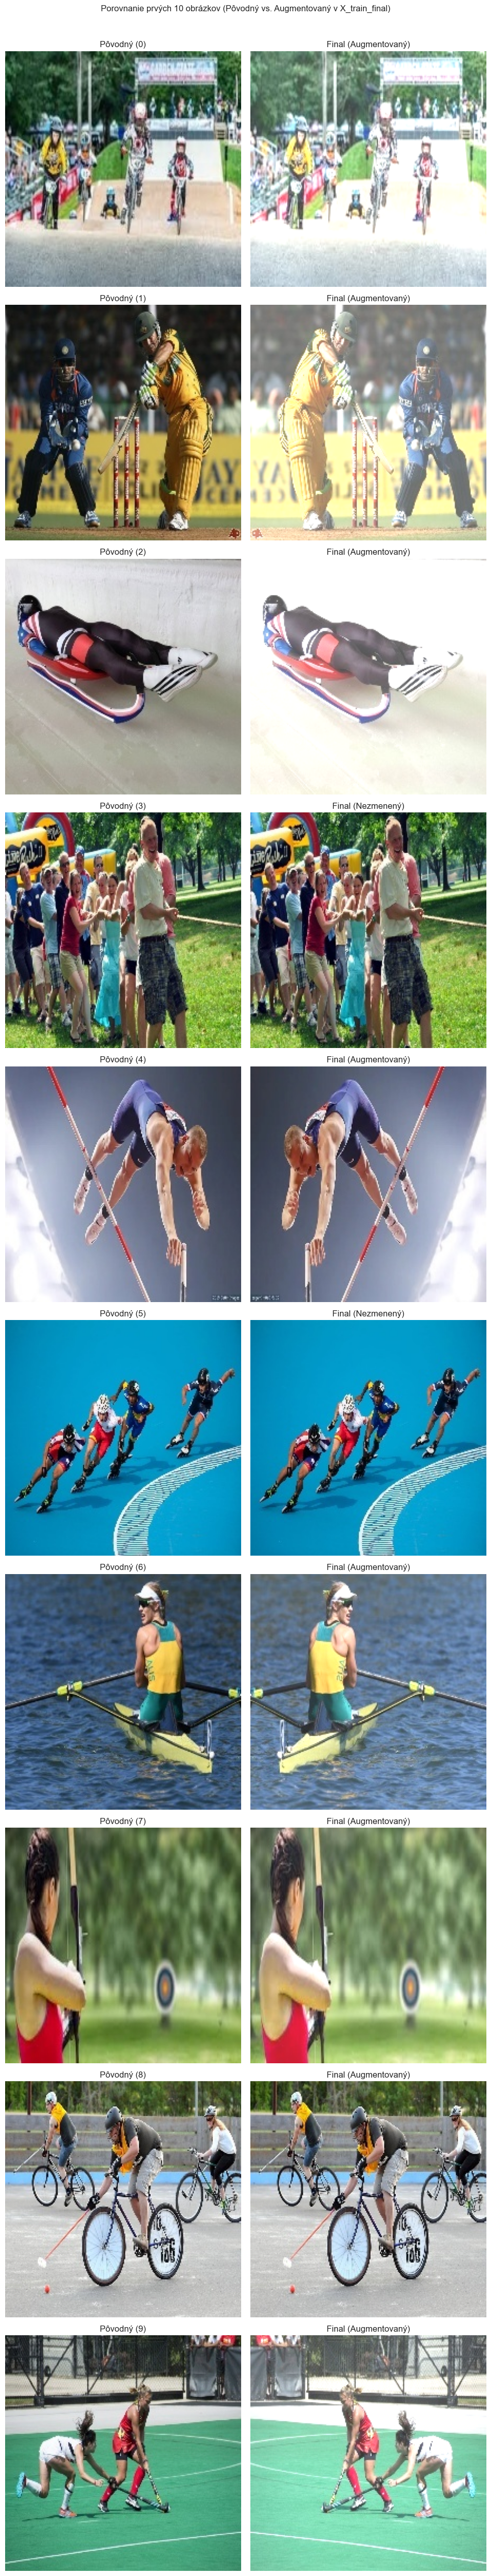

In [22]:
BRIGHTNESS_FACTOR = 0.4        #max rozsah jasu (napr. -0.4 až +0.4)
FLIP_PROBABILITY = 0.5
BRIGHTNESS_PROBABILITY = 0.5

def augment_image_for_training(image_array):
    #pouzijeme kopiu, aby sme neupravovali originál X_train_normalized
    augmented_image = image_array.copy()

    #zmena Jasu
    if random.random() < BRIGHTNESS_PROBABILITY:
        #nahodne vyberieme faktor jasu v rozsahu[-BRIGHTNESS_FACTOR, BRIGHTNESS_FACTOR]
        brightness_delta = random.uniform(-BRIGHTNESS_FACTOR, BRIGHTNESS_FACTOR)
        augmented_image += brightness_delta
        #orezanie hodnot spat do rozsahu 0-1
        augmented_image = np.clip(augmented_image, 0.0, 1.0)

    # preklopenie okolo Y
    if random.random() < FLIP_PROBABILITY:
        augmented_image = np.flip(augmented_image, axis=1)

    return augmented_image

X_train_final_list = []
#ideme cez vsetky obrazky v normalizovanej sade
for i in range(X_train_normalized.shape[0]):
    #sanca na augmentaciu
    final_image = augment_image_for_training(X_train_normalized[i])
    X_train_final_list.append(final_image)

#pretvorime na filane numpy pole
X_train_final = np.array(X_train_final_list)

print(f"Generovanie dokončené. Finálny tvar X_train: {X_train_final.shape}")

#vykreslenie
NUM_IMAGES_TO_SHOW = 10

fig, axes = plt.subplots(NUM_IMAGES_TO_SHOW, 2, figsize=(10, 5 * NUM_IMAGES_TO_SHOW))
plt.suptitle(f"Porovnanie prvých {NUM_IMAGES_TO_SHOW} obrázkov (Pôvodný vs. Augmentovaný v X_train_final)", y=1.005)

#10 obrazkov
for i in range(NUM_IMAGES_TO_SHOW):

    #povodný obrazok
    original_image = X_train_normalized[i]

    #obrazok z novej sady X_train_final
    final_image = X_train_final[i]

    #denormalizacia na 0-255 uint8 pre zobrazenie
    original_display = (original_image * 255).astype(np.uint8)
    final_display = (final_image * 255).astype(np.uint8)

    # Vykreslenie pôvodného
    axes[i, 0].imshow(original_display)
    axes[i, 0].set_title(f"Pôvodný ({i})")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(final_display)

    #info ci sa image zmenil
    if np.array_equal(original_image, final_image):
        title = f"Final (Nezmenený)"
    else:
        title = f"Final (Augmentovaný)"

    axes[i, 1].set_title(title)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


---
Evaluation Matrics

Presnosť

Pomer správne klasifikovaných vzoriek k celkovému počtu vzoriek. Vhodná, ak sú všetky triedy dobre vyvážené (čo sme sa snažili dosiahnuť vyvážením "unknown" triedy).

Weighted F1-Score

Vhodna, ak sú triedy mierne nevyvážené alebo ak ti záleží na rovnomernom výkone vo všetkých triedach.

Presnosť (Precision) pre každú triedu

Z odpovedí pre danú triedu, koľko z nich bolo skutočne správnych. Ukazuje, ako často model robí falošne pozitívne predpovede pre túto triedu (napr. ako často označí "futbal" ako "neznámy").

Confusion Matrix

Nutna na zistenia ko moc sa model myli, porovnanie skutocne vysledko s ocakavanymi